In [ ]:
# This notebook contains code that analyzes our designs using nTimesCoverage (Figure 4)

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import gzip
import math

from copy import deepcopy
from matplotlib import pyplot as plt
import Levenshtein as lev

import torch
from torch.nn import parallel

<h3>Import Data</h3>

In [2]:
with open("./data.pkl", 'rb') as fin:
    mhc1_data, mhc2_data = pickle.load(fin)

In [3]:
# Script for processing data

def makeProductDistribution(population, dataset):
    _,alleles,_ = dataset
    intmap = {}
    for i,allele in enumerate(alleles):
        intmap[allele] = i
    default = len(alleles)
    population = [(frozenset([intmap.get(x[1], default) for x in genotype]),p) for genotype, p in population]
    diploidDistribution = {}
    for i,(haplotype1,p1) in tqdm(enumerate(population), position = 0, leave = True):
        if haplotype1 not in diploidDistribution:
            diploidDistribution[haplotype1] = 0
        diploidDistribution[haplotype1] += p1 ** 2
        for (haplotype2,p2) in population[:i]:
            diplotype = haplotype1.union(haplotype2)
            if diplotype not in diploidDistribution:
                diploidDistribution[diplotype] = 0
            diploidDistribution[diplotype] += 2 * p1 * p2
    return diploidDistribution
    
def makeDiploidDistribution(populations, dataset):
    default = len(dataset[1])
    distributions = [makeProductDistribution(population, dataset) for population in populations]
    for distribution in distributions[1:]:
        for genotype in distribution:
            if genotype not in distributions[0]:
                distributions[0][genotype] = distribution[genotype]
            else:
                distributions[0][genotype] += distribution[genotype]
    distribution = distributions[0]
    indexes = []
    weights = []
    for genotype in distribution:
        weights.append( distribution[genotype]/3 )
        genotype = tuple(genotype)
        if len(genotype) != 6:
            genotype = genotype + ( (default,) * (6-len(genotype)) )
        indexes.append(genotype)
    indexes = np.array(indexes, dtype = np.int16)
    weights = np.array(weights)
    return indexes, weights
    
def reformatData(data):
    _, binary_data, _, population = data
    
    binary_distribution = makeDiploidDistribution(population, binary_data)
    binary_data = torch.tensor(binary_data[0], dtype = torch.float32).cuda(), binary_data[2],\
        binary_distribution[0], torch.tensor(binary_distribution[1], dtype = torch.float32).cuda()
    
    print (binary_data[0].size())
    return binary_data

inputs1_binarized = reformatData(mhc1_data)
inputs2_binarized = reformatData(mhc2_data)

779it [00:00, 1128.42it/s]
1200it [00:01, 639.29it/s]
440it [00:00, 4539.60it/s]
333it [00:00, 2423.57it/s]

torch.Size([1100, 234])


537it [00:00, 2199.85it/s]
920it [00:01, 890.77it/s] 
502it [00:00, 1232.79it/s]


torch.Size([4195, 281])


<h3>Implementation of nTimesCoverage</h3>

In [4]:
# Utility functions

def dedupe_designs(seqs):
    seen = set()
    seqs2 = []
    for seq in seqs:
        if seq not in seen: seqs2.append(seq)
        seen.add(seq)
    return seqs2

In [5]:
#candidates: [candidate, 1 - pMHC hit probability]
#columnIndex: [diplotype, allele in diplotype]
#columnWeights: [diplotype]
#distributions: [dummy, diplotype, distribution]

def nTimesCoverage(candidates, seqs, columnIndex, columnWeights, design, thresholds):
    design = set(design)
    designIndex = [i for i,seq in enumerate(seqs) if seq in design]
    
    candidates_in_design = candidates[designIndex, :]
    numberOfHits = torch.sum( torch.sum(candidates_in_design[:, columnIndex], dim = 2).unsqueeze(2), dim = 0 )
    passed = (numberOfHits >= thresholds.view(1,-1)).float()
    return torch.sum( passed * columnWeights.view(-1,1), dim = 0 ).cpu().numpy()

def nTimesCoverage_trajectory(candidates, seqs, columnIndex, columnWeights, design, thresholds):
    design = dedupe_designs(design)
    seqToIndex = {}
    for i, seq in enumerate(seqs):
        seqToIndex[seq] = i
        
    designIndex = [seqToIndex[seq] for seq in design]
    candidates_in_design = candidates[designIndex, :]
    numberOfHits = torch.cumsum( torch.sum(candidates_in_design[:, columnIndex], dim = 2).unsqueeze(2), dim = 0 )
    stack = torch.stack([torch.sum((row >= thresholds.view(1,-1)).float() * columnWeights.view(-1,1), dim = 0)
         for row in numberOfHits]).cpu().numpy()
    return stack

<h3>Analysis</h3>

In [6]:
credence1 = []
binarized1 = []
credence2 = []
binarized2 = []
for threshold in range(1, 21):
    with open("./outputs/mhc1_binarized_threshold_{}.pkl".format(threshold), 'rb') as fin:
        binarized1.append(pickle.load(fin))
    with open("./outputs/mhc2_binarized_threshold_{}.pkl".format(threshold), 'rb') as fin:
        binarized2.append(pickle.load(fin))
        
with open("./benchmarks.pkl", 'rb') as fin:
    benchmark_trajectories, benchmark_designs = pickle.load(fin)

In [8]:
threshold_20 = torch.tensor(np.arange(1,21,1)).cuda()

In [9]:
# Calculate nTimesCoverage over all benchmarks

benchmark_designs_scores = {}
for design in tqdm(benchmark_designs, position = 0, leave = True):
    if "MHC1" in design:
        data = inputs1_binarized
    elif "MHC2" in design:
        data = inputs2_binarized
    else:
        raise Exception("Unknown MHC Class")
    scores = nTimesCoverage(*data, benchmark_designs[design], threshold_20)
    benchmark_designs_scores[design] = scores
    
benchmark_trajectories_scores = {}
for design in benchmark_trajectories:
    if "MHC1" in design:
        data = inputs1_binarized
    elif "MHC2" in design:
        data = inputs2_binarized
    else:
        raise Exception("Unknown MHC Class")
        
    trajectory = benchmark_trajectories[design]
    trajectoryScores = {}
    for designSize in tqdm(trajectory, position = 0, leave = True):
        scores = nTimesCoverage(*data, trajectory[designSize], threshold_20)
        trajectoryScores[designSize] = scores
    benchmark_trajectories_scores[design] = trajectoryScores
    
# Calculate nTimesCoverage over our designs

def getAllTrajectories(designs, data):
    trajectories = [[] for j in range(20)]
    with tqdm(position = 0, leave = True) as pbar:
        for design_threshold, design in enumerate(designs, 1):
            trajectories[design_threshold-1] = nTimesCoverage_trajectory(*data,design, threshold_20)
            pbar.update(1)
    return trajectories

mhc1_design_scores = getAllTrajectories(binarized1, inputs1_binarized)
mhc2_design_scores = getAllTrajectories(binarized2, inputs2_binarized)

100%|██████████| 96/96 [00:01<00:00, 66.75it/s] 
20it [00:03,  4.86it/s]
20it [00:01, 13.31it/s]


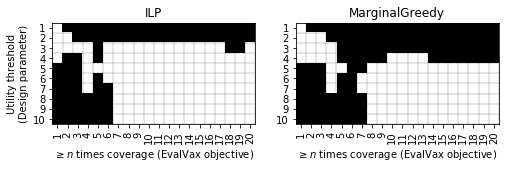

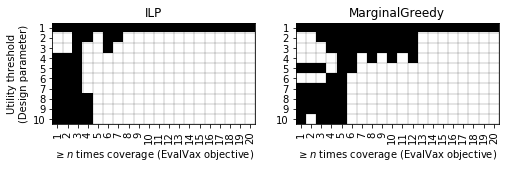

In [10]:
# This block of code was used for generating Figure 4. For additional analysis, benchmark_designs_scores,
# benchmark_trajectories_scores, mhc1_design_scores, and mhc2_design_scores contain all necessary data
# from the experiment

# benchmark_designs_scores is a dictionary that maps from a previous design (indicated by a string
# denoting the source of the design and the MHC class it is for) to an nTimesCoverage array.
# The ith entry (zero indexed) of the array contains the (i+1)-times coverage score.

# benchmark_trajectories_scores is a dictionary of dictionaries. The first index indicates a design
# strategy from Liu et al., while the second index indicates the size of the design. The value mapped
# to by the keys is a an nTimesCoverage array.

# mhc1_design_scores, and mhc2_design_scores are multidimensional lists. The entry in [i][j][k] denotes
# the (k+1)-times coverage score of a design of size j+1 that was optimized via the diminishing returns framework
# with the threshold function U(x) = min(i+1,x).

def compare(optivax, diminishingReturns):
    dr19 = []
    for design in diminishingReturns:
        if len(design) < 19:
            dr19.append(design[-1])
        else:
            dr19.append(design[18].reshape(-1))
            
    _, axs = plt.subplots(1,2, figsize = (8,3))
    for ax, optivax_design in zip(axs, optivax):
        matr = np.array([(optivax_design < design) for design in dr19], dtype = np.float32)
        matr = matr[:10, :]
        ax.imshow(matr, cmap = "gray")
        ax.set_yticks([])
        ax.set_xticks(np.arange(0,20,1))
        ax.set_xticklabels(np.arange(1,21,1), rotation = 90)
        ax.set_xlabel("$\geq n$ times coverage (EvalVax objective)")
        
        ax.set_xticks(np.arange(-0.5, 20, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2, alpha = 0.1)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        
        ax.set_yticks(np.arange(0,10,1))
        ax.set_yticklabels(np.arange(1,11,1), rotation = 0)
    axs[0].set_ylabel("Utility threshold\n(Design parameter)")
    axs[0].set_title("ILP")
    axs[1].set_title("MarginalGreedy")

optivax1 = benchmark_trajectories_scores["ILP_n3_MHC1"][19], benchmark_trajectories_scores["MarginalGreedy_MHC1"][19]
optivax2 = benchmark_trajectories_scores["ILP_n3_MHC2"][19], benchmark_trajectories_scores["MarginalGreedy_MHC2"][19]
compare(optivax1, mhc1_design_scores)
compare(optivax2, mhc2_design_scores)